# Quantum Polynomial Network for qubits
Quantum Neural Network (QNN) that compute a property (purity or entropy) of a given state

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import pennylane as qml
from pennylane import numpy as np
from pennylane_forest.ops import CCNOT
from scipy.optimize import minimize
from scipy.optimize import fmin_l_bfgs_b

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)

## Constants

### Dataset

In [4]:
data_folder = "data/discrete/entropy/"
property_name = "entropy"

n_qubits_rho = 1
n_qubits_psi = n_qubits_rho * 2 # for purification
n_qubits_pn = n_qubits_rho * 2 + 1 # input: [σ, ρ, ρ]
n_qubits_total = n_qubits_psi * 2 + 1
# modes_meas = [1,3]
modes_meas = [0]
modes_pn = [0,1,3]
modes_sp_1 = [1,2]
modes_sp_2 = [3,4]

ratio_train = 0.75

### Architectures

In [5]:
hidden_size = 20

## Loading the dataset

### Loading the files

In [6]:
rhos = np.load(os.path.join(data_folder, "rhos.npy"))

if property_name == "purity":
    properties = np.load(os.path.join(data_folder, "purities.npy"))
elif property_name == "entropy":
    properties = np.load(os.path.join(data_folder, "entropies.npy"))
    
list_params = np.load(os.path.join(data_folder, "list_params.npy"))

In [7]:
n_samples = len(rhos)
n_samples_train = int(ratio_train*n_samples)
n_samples_test = n_samples - n_samples_train

In [8]:
samples_idx = np.random.choice(n_samples, size=n_samples, replace=False)
rhos = rhos[samples_idx]
properties = properties[samples_idx]
list_params = list_params[samples_idx]

### Dividing train and test

In [9]:
X_train = list_params[:n_samples_train]
X_test = list_params[n_samples_train:]

Y_train = properties[:n_samples_train]
Y_test = properties[n_samples_train:]
print(len(X_train))

300


## Networks

In [10]:
# dev1 = qml.device('default.qubit', wires=n_qubits_total)
# dev1 = qml.device('projectq.simulator', wires=4)
dev1 = qml.device('forest.wavefunction', wires=n_qubits_total)
# dev1 = qml.device('forest.qvm', device='4q', noisy=False, shots=)

### Useful gates

In [11]:
def CRZ(theta, wires):
    qml.RZ(theta, wires[1])
    qml.CNOT(wires)
    qml.RZ(-theta*0.5, wires[1])
    qml.CNOT(wires)
    qml.RZ(-theta*0.5, wires[1])

In [12]:
def CRY(theta, wires):
    qml.RY(theta, wires[1])
    qml.CNOT(wires)
    qml.RY(-theta*0.5, wires[1])
    qml.CNOT(wires)
    qml.RY(-theta*0.5, wires[1])

### Universal block

In [13]:
def universal_block(params, q):
    qml.RZ(params[0], wires=q[0])
    qml.RY(params[1], wires=q[0])
    qml.RZ(params[2], wires=q[0])
    qml.RZ(params[3], wires=q[1])
    qml.RY(params[4], wires=q[1])
    qml.RZ(params[5], wires=q[1])
    qml.CNOT(wires=[q[1],q[0]])
    qml.RZ(params[6], wires=q[0])
    qml.RY(params[7], wires=q[1])
    qml.CNOT(wires=[q[0],q[1]])
    qml.RY(params[8], wires=q[1])
    qml.CNOT(wires=[q[1],q[0]])
    qml.RZ(params[9], wires=q[0])
    qml.RY(params[10], wires=q[0])
    qml.RZ(params[11], wires=q[0])
    qml.RZ(params[12], wires=q[1])
    qml.RY(params[13], wires=q[1])
    qml.RZ(params[14], wires=q[1])

In [14]:
def controlled_block(params, q):
    CRZ(params[0], wires=[q[0], q[1]])
    CRY(params[1], wires=[q[0], q[1]])
    CRZ(params[2], wires=[q[0], q[1]])
    
    CRZ(params[3], wires=[q[0], q[2]])
    CRY(params[4], wires=[q[0], q[2]])
    CRZ(params[5], wires=[q[0], q[2]])
    
    CCNOT(wires=[q[0], q[2], q[1]])
    CRZ(params[6], wires=[q[0], q[1]])
    CRY(params[7], wires=[q[0], q[2]])
    
    CCNOT(wires=[q[0], q[1],q[2]])
    CRY(params[8], wires=[q[0], q[2]])
    CCNOT(wires=[q[0], q[2],q[1]])
    
    CRZ(params[9], wires=[q[0], q[1]])
    CRY(params[10], wires=[q[0], q[1]])
    CRZ(params[11], wires=[q[0], q[1]])
    
    CRZ(params[12], wires=[q[0], q[2]])
    CRY(params[13], wires=[q[0], q[2]])
    CRZ(params[14], wires=[q[0], q[2]])

In [15]:
def arthur_block(params, q):
    CRZ(params[0], wires=[q[0], q[1]])
    CRZ(params[1], wires=[q[0], q[2]])
    qml.CNOT(wires=[q[0],q[1]])
    qml.CNOT(wires=[q[0],q[2]])
    CRY(params[2], wires=[q[0],q[2]])
    CCNOT(wires=[q[0],q[2],q[1]])
    

### State preparation

In [16]:
def sp_network(params, q):
    universal_block(params, q)

### Polynomial network

In [17]:
def pn_network(params, q):
    universal_block(params, q)
#     qml.Hadamard(q[0])
#     controlled_block(params, q)
#     qml.Hadamard(q[0])

### End network

In [18]:
class EndNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EndNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 1) 

#         self.fc1 = nn.Linear(input_size, hidden_size) 
#         self.fc2 = nn.Linear(hidden_size, hidden_size)  
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.fc4 = nn.Linear(hidden_size, 1)
        
        for param in self.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
    
    def forward(self, x):
        out = x.float()
        out = self.fc1(out)
#         out = F.relu(self.fc1(out))
#         out = F.relu(self.fc2(out))
#         out = F.relu(self.fc3(out))
#         out = F.relu(self.fc4(out))

        return out

In [19]:
# end_network = EndNetwork(len(modes_meas), hidden_size)
end_network = EndNetwork(1, hidden_size)

In [20]:
end_params = end_network.parameters()

In [21]:
# def end_network(params, x):
#     return params.dot(x)

### Total network

In [22]:
@qml.qnode(dev1, interface='torch')
def total_qnn(sp_params, pn_params):
#     sp_network(sp_params, [0,1])
#     sp_network(sp_params, [2,3])
#     pn_network(pn_params, modes_meas)
    sp_network(sp_params, modes_sp_1)
    sp_network(sp_params, modes_sp_2)
    pn_network(pn_params, modes_pn)
    
#     ZZ = np.diag([1,-1,-1,1])
#     return tuple(qml.expval.PauliZ(mode) for mode in modes_meas) \
#          + (qml.expval.Hermitian(ZZ, wires=modes_meas),)
    return tuple(qml.expval.PauliZ(mode) for mode in modes_meas)

In [23]:
def total_network(sp_params, pn_params):
    return end_network.forward(total_qnn(sp_params, pn_params))

In [24]:
total_network(list_params[0], list_params[0])

tensor([-0.8772], grad_fn=<AddBackward0>)

## Cost and optimizer

### Parameters

In [25]:
pn_params = torch.tensor(np.random.normal(size=15, scale=0.1), requires_grad=True)
# end_params = torch.tensor(np.random.normal(size=len(modes_meas), scale=0.1), requires_grad=True)
# pn_params = np.random.normal(size=15, scale=0.1)
# end_params = np.random.normal(size=len(modes_meas), scale=0.1)

### Cost function

In [26]:
def property_mse(prop1, prop2):
    return torch.mean((prop1 - prop2)**2)

In [27]:
def cost(sp_params, pn_params, property_true):
    property_out = total_network(sp_params, pn_params)
    return property_mse(property_out, property_true)

### Training without gradient

In [28]:
X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)

In [29]:
def cost_total(params):
    pn_params = params[:15]
    end_params = params[15:]
    return np.mean([cost(X_train_tensor[i], pn_params, Y_train_tensor[i])
                    for i in range(16)])

In [30]:
# import time
# start = time.time()
# result = fmin_l_bfgs_b(cost_total, np.concatenate([pn_params, end_params]),
#                        maxiter=1, approx_grad=True)
# print(time.time() - start)

In [31]:
# result

### Optimizer

In [32]:
opt = torch.optim.Adam([pn_params] + list(end_network.parameters()), lr = 0.1)

## Training

In [33]:
cost_train_list = []
cost_test_list = []
iter_train_list = []
iter_test_list = []
i = 0

In [50]:
nb_epochs = 30000
lr = 50e-4
batch_size = 16
n_iters_test = 2
opt.lr = lr

for i in range(i, nb_epochs+i):
    samples_idx = np.random.choice(n_samples_train, size=n_samples_train, replace=False)
    
    opt.zero_grad()
    cost_train_epoch = []
    cost_train_batch = 0
    for i_sample in range(n_samples_train):
        sp_params = torch.tensor(X_train[samples_idx[i_sample]])
        property_true = torch.tensor(Y_train[samples_idx[i_sample]])
      
        cost_train_batch += cost(sp_params, pn_params, property_true) 

        if (i_sample != 0 and i_sample % batch_size == 0) or i_sample == n_samples_train-1:
            cost_train_epoch.append(cost_train_batch.detach().numpy() / batch_size)
            clear_output(wait=True)
            print('Step: {}/{}'.format(i_sample, n_samples_train))
            print('Cost train after step {:5d}: {: .10f}'.format(i, np.mean(cost_train_epoch)))
            if i > n_iters_test:
                print('Cost test after step {:5d}: {: .10f}'.format(i, cost_test_list[-1]))
            
            cost_train_batch.backward()
            opt.step()
            opt.zero_grad()
            cost_train_batch = 0
            
    if i % n_iters_test == 0:
        samples_idx = np.random.choice(n_samples_test, size=n_samples_test, replace=False)
        cost_test_sample = []
        for i_sample in range(n_samples_test):
            sp_params = torch.tensor(X_test[samples_idx[i_sample]])
            property_true = torch.tensor(Y_test[samples_idx[i_sample]])
            cost_test_sample.append(cost(sp_params, pn_params, property_true).detach().numpy())
        cost_test_list.append(np.mean(cost_test_sample))
        iter_test_list.append(i)
        
    cost_train_list.append(np.mean(cost_train_epoch))
    iter_train_list.append(i)
    
i = i+1

Step: 16/300
Cost train after step   113:  0.0010367973
Cost test after step   113:  0.0006734831


KeyboardInterrupt: 

# Visualization and result

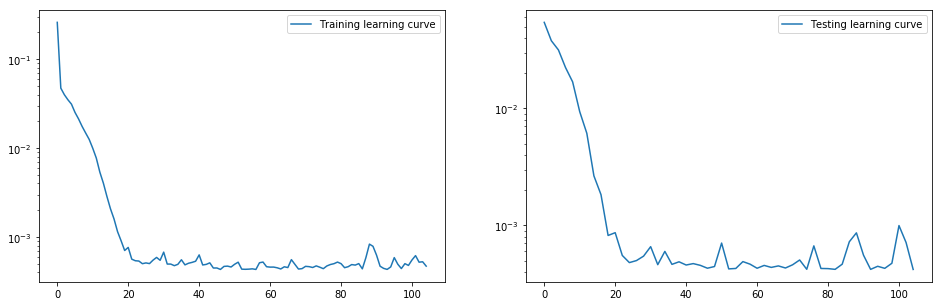

In [47]:
start = 0
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.plot(iter_train_list[start:], cost_train_list[start:], 
         label="Training learning curve")
plt.legend()
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(iter_test_list[np.where(np.array(iter_test_list) >= start)[0][0]:], cost_test_list[np.where(np.array(iter_test_list) >= start)[0][0]:], 
         label="Testing learning curve")
plt.legend()
plt.yscale('log')

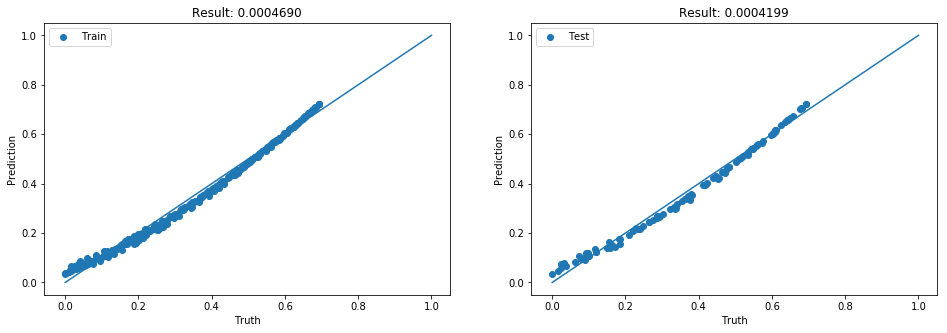

In [49]:
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.title("Result: {:0.7f}".format(cost_train_list[-1]))

property_pred = []
for j in range(n_samples_train):
    property_pred.append(total_network(torch.tensor(X_train[j]), pn_params).detach().numpy())

plt.scatter(Y_train, property_pred, label="Train")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

plt.subplot(1,2,2)
plt.title("Result: {:0.7f}".format(cost_test_list[-1]))

property_pred = []
for j in range(n_samples_test):
    property_pred.append(total_network(torch.tensor(X_test[j]), pn_params).detach().numpy())
    
plt.scatter(Y_test, property_pred, label="Test")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

plt.savefig("experiments/discrete/entropy/corr_net/truth-predict.png")

## Debug

In [51]:
pn_params

tensor([-1.6350,  1.5216, -1.5486, -1.2801,  1.5132, -1.5741, -0.0465,  0.0101,
        -0.0141, -1.5606,  1.4632, -1.5206, -1.5587,  1.5669, -1.8560],
       dtype=torch.float64, requires_grad=True)

In [ ]:
end_params